In [1]:
from pathgen.utils.seeds import set_seed
from pathgen.utils.paths import project_root

experiment_name = "paper"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123
set_seed(global_seed)

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
from torch import nn
import torch.nn.functional as F
from pytorch_lightning.metrics import Accuracy

def accuracy(logits, y):
    # pred = torch.log_softmax(logits, dim=1)
    # correct = pred.argmax(dim=1).eq(y).sum().item()
    correct = logits.argmax(dim=1).eq(y).sum().item()
    total = len(y)
    accu = correct / total
    return accu


class PatchClassifier(pl.LightningModule):
    def __init__(self, model, learning_rate=2e-4) -> None:
        super().__init__()
        self.model = model
        #self.accuracy = Accuracy()
        # self.accuracy = accuracy
        
        # log hyperparameters
        # self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.test_pred = []
        self.test_y = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('val_loss', loss, prog_bar=False, on_epoch=True, on_step=False)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # log the results so we can compute epoch wide metrics
        pred = logits.argmax(dim=1)
        pred_list = pred.cpu().numpy().tolist()
        #print(pred_list)
        y_list = y.cpu().numpy().tolist()
        #print(y_list)
        self.test_pred.append(pred_list)
        self.test_y.append(y_list)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), 
                                    lr=0.001, 
                                    momentum=0.9, 
                                    weight_decay=0.0005)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5),
            'interval': 'step' 
        }
        return [optimizer], [scheduler]
    
    #def configure_optimizers(self):
     #  optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #return optimizer    

In [3]:

in_channels = 3
number_of_filters = 32
kernel_size = 3
stride = 1

def conv2d_output_size(w, h, in_channels, number_of_filters, kernel_size, stride, padding=0):
    out_width = int((w - kernel_size + 2*padding)/stride + 1)
    out_height = int((h - kernel_size + 2*padding)/stride + 1)
    out_channels = number_of_filters
    return out_width, out_height, out_channels

w2, h2, d2 = conv2d_output_size(64, 64, 3, 32, 3, 1, 0)
w3, h3, d3 = conv2d_output_size(w2, h2, d2, 32, 3, 1, 0)
w4, h4, d4 = conv2d_output_size(w3, h3, d3, 64, 3, 1, 0)
wo, ho, do = conv2d_output_size(w4, h4, d4, 64, 3, 1, 0)
print(wo * ho * do)
print(wo, ho, do)

200704
56 56 64


In [4]:
import torch
from torch import nn
import torch.nn.functional as F

class Backbone(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)
        print(n_sizes)
        
        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x

In [5]:
%%time

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torchvision.transforms as transforms

# prepare our data
batch_size = 128
max_epochs = 50

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = ImageFolder(experiment_root / 'patches' / 'train', transform=transform)  # 70,000 samples (35,000 per class)
valid_set = ImageFolder(experiment_root / 'patches' / 'valid', transform=transform)  # 30,000 samples (15,000 per class)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(global_seed), num_workers=32)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, worker_init_fn=np.random.seed(global_seed), num_workers=32)

# configure logging and checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath=experiment_root / "patch_model",
    filename=f"checkpoint.ckpt",
    save_top_k=1,
    mode="max",
)

early_stop_callback = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00,
    patience=5,
    verbose=False,
    mode='max'
)

csv_logger = pl_loggers.CSVLogger(experiment_root / 'logs', name='patch_classifier_real', version=0)

# train our model
model = Backbone((3, 64, 64), 2)

classifier = PatchClassifier(model)
trainer = pl.Trainer(callbacks=[checkpoint_callback, early_stop_callback], log_every_n_steps=1, gpus=1, max_epochs=max_epochs, logger=csv_logger, auto_select_gpus=False)
trainer.fit(classifier, train_dataloader=train_loader, val_dataloaders=valid_loader)

/home/ubuntu/anaconda3/envs/pathgen/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Checkpoint directory /home/ubuntu/pathgen/experiments/paper/patch_model exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


10816



  | Name  | Type     | Params
-----------------------------------
0 | model | Backbone | 5.7 M 
-----------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.679    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3min 4s, sys: 2min 22s, total: 5min 27s
Wall time: 6min 25s


1

In [6]:
# test
test_set = ImageFolder(experiment_root / 'patches' / 'test', transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=np.random.seed(global_seed), num_workers=32)
trainer.test(test_dataloaders=test_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7768999934196472, 'test_loss': 0.48668986558914185}
--------------------------------------------------------------------------------


[{'test_loss': 0.48668986558914185, 'test_acc': 0.7768999934196472}]

In [7]:
import pandas as pd

log_df = pd.read_csv(experiment_root / 'logs/patch_classifier_real/version_0/metrics.csv')
train_log = log_df[['train_loss', 'train_acc', 'epoch']].dropna()
valid_log = log_df[['val_loss', 'val_acc', 'epoch']].dropna()
test_log = log_df[['test_loss', 'test_acc', 'epoch']].dropna()

In [8]:
valid_log

,val_loss,val_acc,epoch
1,0.690169,0.707567,0
3,0.634604,0.759300,1
5,0.475377,0.792033,2
7,0.439080,0.808333,3
9,0.444977,0.797567,4
11,0.421799,0.817533,5
13,0.415102,0.820500,6
15,0.403447,0.824800,7
17,0.411664,0.817700,8
19,0.405247,0.825933,9


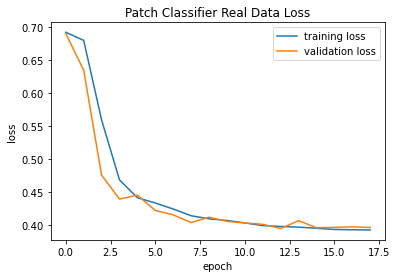

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_log.epoch, train_log.train_loss, label="training loss")
plt.plot(valid_log.epoch, valid_log.val_loss, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Patch Classifier Real Data Loss")
plt.legend()

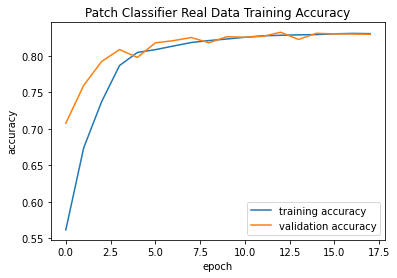

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_log.epoch, train_log.train_acc, label="training accuracy")
plt.plot(valid_log.epoch, valid_log.val_acc, label="validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Patch Classifier Real Data Training Accuracy")
plt.legend()

In [11]:
len(classifier.test_pred), len(classifier.test_y)
expected = [x for xs in classifier.test_y for x in xs]
predicted = [x for xs in classifier.test_pred for x in xs] 

              precision    recall  f1-score   support

      normal       0.74      0.85      0.79     15000
       tumor       0.83      0.70      0.76     15000

    accuracy                           0.78     30000
   macro avg       0.78      0.78      0.78     30000
weighted avg       0.78      0.78      0.78     30000



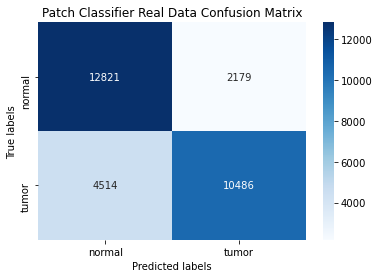

In [12]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

print(metrics.classification_report(expected, predicted, labels=[0, 1], target_names=['normal', 'tumor']))

cm = metrics.confusion_matrix(expected, predicted)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Patch Classifier Real Data Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'tumor']); ax.yaxis.set_ticklabels(['normal', 'tumor']);